# Rede Neural Recorrente - Série Temporal com vários previsores

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

%matplotlib inline

## Obter os dados de treino

In [2]:
data_train = pd.read_csv("poluicao.csv")

In [3]:
data_train.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
data_train.shape

(43824, 13)

## Pré-Processamento dos dados de treino - Apagar dados Ausentes

In [5]:
data_train.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [6]:
# Como apenas 2067 linhas em 43824 têm valores ausentes optou-se por apagar essas linhas.
data_train = data_train.dropna()

In [7]:
# Confirmação de ter-se removido apenas 3 linhas
data_train.shape

(41757, 13)

In [8]:
# Confirmação da anão existencia de valores nulos
data_train.isnull().sum()

No       0
year     0
month    0
day      0
hour     0
pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64

In [30]:
data_train["pm2.5"].iloc[10:15]

34    140.0
35    152.0
36    148.0
37    164.0
38    158.0
Name: pm2.5, dtype: float64

## Pré-Processamento dos dados de treino- Normalização das Variaveis

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))

In [12]:
# Normalizar das variaveis de entrada
# Vão-se mormalizar todas as variaveis utilizadas para fazer o treino do modelo.

# "No" é o número do registro
# "Year", "month", "day" e "hour" são as informações temporais que não são utilizadas para análise
# "Cbwd" é um atributo de texto que não está relacionado com as previsões

# Deveria ter passado algumas variaveis para float, mas o MinMAxScaler fez isso automaticamente.
scaler.fit(data_train.drop(["No", "year", "month", "day", "hour", "pm2.5", "cbwd"], axis=1))

C:\Users\Bruno\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [13]:
# Array com as variaveis de entrada normalizadas.
X_train_norm = scaler.fit_transform(data_train.drop(["No", "year", "month", "day", "hour", "pm2.5", "cbwd"], axis=1))

C:\Users\Bruno\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [14]:
X_train_norm.shape

(41757, 6)

In [15]:
# Ajustar e normalizar a variavel de saida.
# É necessário ajustar porque o scaler foi ajustado anteriormente a um array (41757,6) e quer-se ajustar a um array (41757,1).
y_train_norm = scaler.fit_transform(data_train.drop(["No","year","month","day","hour","DEWP","TEMP","PRES","cbwd",
                                                     "Iws","Is","Ir"], axis=1))

In [16]:
y_train_norm.shape

(41757, 1)

In [17]:
y_train_norm[0:5]

array([[0.12977867],
       [0.14889336],
       [0.15995976],
       [0.18209256],
       [0.138833  ]])

In [25]:
a = scaler.inverse_transform(y_train_norm)
a

array([[129.],
       [148.],
       [159.],
       ...,
       [ 10.],
       [  8.],
       [ 12.]])

## Divisão dos dados de treino

In [19]:
# Prever o nivel de pluição com base nas 10 horas anteriores.

X_train = [] # vector com os dados dos 10 dias anteriores.
y_train = [] # vector com o nivel de pluição no dia 11.

In [21]:
# Só é possivel prever o nivel de pluição desda a 10ª hora até à hora 41757. Porque só se tem registro de 41757 horas e 
# estabeleceu-se como critério utilizar as 10 horas anteriores para fazer uma previsão.

for i in range(10, 41757):
    X_train.append(X_train_norm[i-10:i,0:6]) # valores das variaveis de entrada
    y_train.append(y_train_norm[i, 0]) # valor do nivel da pluição

In [22]:
# Converter os vectores(listas) em arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [23]:
# 41747 registros com as 10 horas anteriores para as 6 variaveis utilizadas para fazer a previsão.
# Para prever a pluição nessas 41747 horas utilizam-se as 10 horas anteriores a cada hora a prever.
X_train.shape

(41747, 10, 6)

In [24]:
# X_train[0,:,0]: DEWP nos primeiros 10 dias. Utilizado para prever o nivel de poluição no 10º dia.
# X_train[0,:,1]: TEMP nos primeiros 10 dias. Utilizado para prever o nivel de poluição no 10º dia.
# X_train[0,:,2]: PRES nos primeiros 10 dias. Utilizado para prever o nivel de poluição no 10º dia.
# X_train[0,:,3]: Iws nos primeiros 10 dias. Utilizado para prever o nivel de poluição no 10º dia.
# X_train[0,:,4]: ls nos primeiros 10 dias. Utilizado para prever o nivel de poluição no 10º dia.
# X_train[0,:,5]: lr nos primeiros 10 dias. Utilizado para prever o nivel de poluição no 10º dia.
# X_train[0,:,5]: DEWP entre a hora 1 e 11. Utilizado para prever o nivel de poluição no 11º dia.

X_train[0,:,0]

array([0.35294118, 0.36764706, 0.42647059, 0.48529412, 0.48529412,
       0.48529412, 0.48529412, 0.48529412, 0.47058824, 0.48529412])

In [25]:
# y_train[0:1]: nivel de poluição (normalizado) no dia 11º dia.
# y_train[1:2] nivel de poluição (normalizado) no dia 12º dia.
y_train[0:1]

array([0.14084507])

## Modelo Rede Neural Recorrente

In [26]:
# sequential - A informação é passada de uma camada para a camada seguinte

#-------------------------------------------------------------------------------------------------------------------------------
# Camada LSTM

# LSTM - Long short term memory. AS redes neurais simples têm dificuldade em "aprender" alguns tipos de padrões mais complexos.
# Nesses casos pode-se utilizar o tipo de rede neural recorrente LSTM que aprende "dependencias" de longo prazo.

# As redes neurais recorrentes simples armazenam as informações no tempo atraves de loops( o neuronio apenas aponta para ele 
# mesmo e para a camada seguinte). Isto permte que a informação persista.
# As redes neurais recorrentes LSTM para alem disso têm celulas de memoria e manipulam essas celulas de modo a filtrar e 
# armazenar a informação importante nessas celulas.

# As redes neurais recorrentes ajudam no problema do gradiente desaparecendo(vanish gradient). No ajuste dos pesos ao se
# utilizar a descida do gradiente e a sua actualização atraves de backpropagation em primeiro faz-se os calculos da camada
# de entrada para a camada de saida. Os pesos são depois actalizados a partir da camada de saida para a camada de entrada. Os
# pesos vão sendo actualizados utilizando o learning rate(maiores alterações nas 1ªs camadas). Caso se tenha muitos loops
# as ultimas actualizações do gradiente são muito pequenas, o que faz com que o peso não tenha alteração no seu valor.

# Número de celulas de memoria(units): Número de vezes(loops) em que a informação é passada ao mesmo neuronio e a camada 
# seguinte (numero de cópias da camada). Deve ser um valor alto para adicinonar mais dimensionalidade e decorar a tendencia ao 
# longo do tempo.

# Return_sequence: True. Apenas se utilizada quando se tem mais de uma camada LSTM. Indica que a informação será passada para a
# camada seguinte.

# input_shape: Número de registros utilizados para fazer a previsão(90) e número de variaveis de entrada(6).
#-------------------------------------------------------------------------------------------------------------------------------
# Camada densa

# Todos os neuronios da ultima camada( segunda camada LSTM) estão conectados à camada de saida. Nas camadas LSTM isso tambem
# acontece.

# units: 1. Só se quer prever o valor do nivel de poluição.
# activation: linear. É um problema de regressão. Como os valores estão normalizados(entre 0 e 1) caso se utiliza-se a função
# sigmoid tambem se retornaria valores entre 0 e 1.
#-------------------------------------------------------------------------------------------------------------------------------

model = models.Sequential()
model.add(layers.LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 6)))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(units=1, activation="linear"))

In [27]:
# optimizer: pode-se utilizar o RMSprop, indicado para redes neurais recorrentes, ou o adam que obtem resultados semelhantes.
# loss: mean_squared_error é o parametro utilizado para problemas de regressão.

# Compilação do modelo
model.compile(optimizer="RMSprop", loss="mean_squared_error", metrics=["mean_absolute_error"])

In [28]:
# Ajustar os dados de entrada de treino aos dados de saida para treinar o modelo.
model.fit(X_train, y_train, epochs=100, batch_size=64)

Train on 41747 samples
Epoch 1/100
41747/41747 [==============================] - 33s 780us/sample - loss: 0.0073 - mean_absolute_error: 0.0620
Epoch 2/100
41747/41747 [==============================] - 26s 633us/sample - loss: 0.0061 - mean_absolute_error: 0.0559
Epoch 3/100
41747/41747 [==============================] - 27s 651us/sample - loss: 0.0057 - mean_absolute_error: 0.0536
Epoch 4/100
41747/41747 [==============================] - 28s 664us/sample - loss: 0.0056 - mean_absolute_error: 0.0525
Epoch 5/100
41747/41747 [==============================] - 28s 667us/sample - loss: 0.0054 - mean_absolute_error: 0.0517
Epoch 6/100
41747/41747 [==============================] - 29s 686us/sample - loss: 0.0054 - mean_absolute_error: 0.0515
Epoch 7/100
41747/41747 [==============================] - 30s 711us/sample - loss: 0.0052 - mean_absolute_error: 0.0507
Epoch 8/100
41747/41747 [==============================] - 29s 699us/sample - loss: 0.0052 - mean_absolute_error: 0.0505
Epoch 9/1

## Previsão e Avaliação do Modelo RNN

In [53]:
# Prever os dados de teste para avaliar o modelo

# A previsão deveria ser feita para os dados de treino para avaliar o comportamento do modelo para dados não vistos.
# Neste caso utilizaram-se os dados de treino para fazer previsões e avaliar o modelo(apesar do modelo já ter sido avaliado
# para estes dados enquanto o modelo era ajustado).
# Deveria dividir a base de dados original em traino e teste ou efectuar a cross-validation.
predictions = model.predict(X_train)

In [55]:
# Reverter a normalização do X_test para comparar os valores das acções
predictions = scaler.inverse_transform(predictions)

In [56]:
# Reverter a normalização do y_test para comparar os valores da poluição
y_test = scaler.inverse_transform(y_train.reshape(-1,1))http://localhost:8888/notebooks/Desktop/Python/Deep%20Learning%20com%20python%20az%20curso%20completo/Notebooks%20Meus/3%20Redes%20Neurais%20Recorrentes/2%20S%C3%A9rie%20Temporal%20-%20V%C3%A1rios%20previsores/Ex2SerieTemporalVariosPrevisores.ipynb#

In [59]:
pd.DataFrame({"Predictions": predictions[:,0], "y_test":y_test[:,0]}).head()

,Predictions,y_test
0,100.011406,140.0
1,100.493668,152.0
2,128.220535,148.0
3,151.347778,164.0
4,134.658813,158.0


### Avaliação do Modelo

In [60]:
from sklearn import metrics

In [61]:
# O MSE é muito mais elevado porque penaliza os desvios grandes(são elevados ao quadrado).
# O MAE de 35 significa que a poluição varia +- 35 unidades. 
print("MAE", metrics.mean_absolute_error(y_test, predictions))
print("MSE", metrics.mean_squared_error(y_test, predictions))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE 35.05902072611028
MSE 2549.2246715260185
RMSE 50.48984721234576


In [62]:
### Resíduos

Text(0.5, 0, 'y_test-predictions')

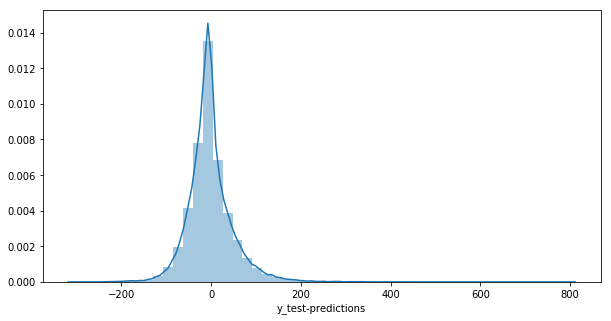

In [63]:
# Histograma de Residuos 
# O gráfico parece aproximar-se de uma distriuição normal, onde os residuos são proximos de zero.

plt.figure(figsize=(10,5))
sns.distplot(y_test-predictions)
plt.xlabel("y_test-predictions")

In [64]:
### Gráfico poluição real vs poluição prevista

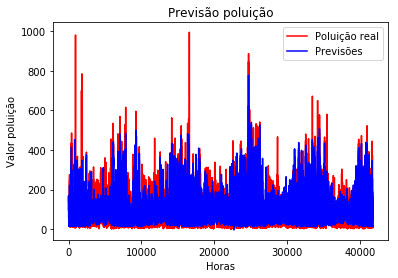

In [65]:
# O gráfico gerado será de barras porque tem-se muitos registros
plt.plot(y_test, color = 'red', label = 'Poluição real')
plt.plot(predictions, color = 'blue', label = 'Previsões')
plt.title('Previsão poluição')
plt.xlabel('Horas')
plt.ylabel('Valor poluição')
plt.legend()
plt.show()